# Optimization

Gradient descent function for test function


In [1]:
using PyPlot
using PyCall
using LinearAlgebra
using ImageFiltering

include("acoustic_solver.jl")
include("sinkhorn.jl")
include("adj_method.jl")

grad_sinkhorn (generic function with 1 method)

In [93]:
# define function
N = 101;
x1 = range(-1, stop=1, length=N)
x2 = range(-1, stop=1, length=N)

X1 = repeat(x1, 1, N)
X2 = repeat(x2', N, 1)

function f(X1, X2)
    return f = 0.5 .* X1.^2 + X2.^2 + 0.2.*(X1.=0.5).*exp.(X2)
end

function eval_f(x)
    x1 = x[1]
    x2 = x[2]
    return f = 0.5 * (x1-1)^2 + (x2-1)^2 
#     + 0.2*(x1-0.5)*exp(x2)
end

function grad_f(x)
    x1 = x[1]
    x2 = x[2]
#     return [x1+0.2*exp(x2); 2*x2+0.2*(x1-0.5)*exp(x2)]
    return [x1-1; 2*(x2-1)]
end

function op_fn(x)
    return eval_f(x), grad_f(x)
end

function line_search_backtracking(op_fn, xk, fk, gradk, alpha, min_value, max_value; rho=0.9, c=0.9, maxSearchTime=30)
    pk = -gradk
    
    xkk = xk+alpha*pk
    xkk[findall(ind->ind<min_value,xk)] .= min_value
    xkk[findall(ind->ind>max_value,xk)] .= max_value
    fk1, gradk1 = op_fn(xkk)
    println(fk1)

    searchTime = 0
    for iter = 1:maxSearchTime
        if fk1 < fk + c*alpha*sum(gradk.*pk)
            break
        end
        alpha = rho * alpha
        
        xkk = xk+alpha*pk
        xkk[findall(ind->ind<min_value,xk)] .= min_value
        xkk[findall(ind->ind>max_value,xk)] .= max_value
        fk1, gradk1 = op_fn(xkk)
        
        searchTime += 1
    end

    if searchTime == maxSearchTime
        println("Line search failed. Search time: ", searchTime, ". Try to decrease search coef c.")
        xk1 = xk
        fk1 = fk
        gradk1 = gradk
    elseif searchTime < maxSearchTime
        println("Line search succeed. Search time: ", searchTime, ".")
        xk1 = xkk
    end
    
    return xk1, fk1, gradk1
end

function gradient_descent(fn, x0, alpha, iterNum, min_value, max_value; rho=0.9, c=0.9, maxSearchTime=30)
#     fn: returns both value of f and gradient of f
    xk = x0[:]
    fn_value = zeros(iterNum+1)
    
    fk, gradk = fn(xk)
    fn_value[1] = fk
    
    for iter = 1:iterNum
        println("Main iteration: ", iter)
        
        xk1, fk, gradk = line_search_backtracking(fn, xk, fk, gradk, alpha, min_value, max_value; rho=rho, c=c, maxSearchTime=maxSearchTime)
        
        if xk1 == xk
            xk[findall(ind->ind<min_value,xk)] .= min_value
            xk[findall(ind->ind>max_value,xk)] .= max_value
            println("Line search Failed. Try decrease line search coef alpha. Interupt.")
            println("--------------------------------")
            break
        else
            xk[findall(ind->ind<min_value,xk)] .= min_value
            xk[findall(ind->ind>max_value,xk)] .= max_value
            xk = xk1
        end
        
        fn_value[iter+1] = fk
        println("--------------------------------")

    end
    return xk, fn_value
end

gradient_descent (generic function with 1 method)

In [14]:
x0 = [3,3]
f0 = eval_f(x0)
grad0 = grad_f(x0)

xk, fn_value = gradient_descent(op_fn, x0, 3, 30, -3, 3; maxSearchTime=20, c=0.5)

Main iteration: 1
Line search succeed. Search time: 17.
--------------------------------
Main iteration: 2
Line search succeed. Search time: 11.
--------------------------------
Main iteration: 3
Line search succeed. Search time: 11.
--------------------------------
Main iteration: 4
Line search succeed. Search time: 13.
--------------------------------
Main iteration: 5
Line search succeed. Search time: 15.
--------------------------------
Main iteration: 6
Line search succeed. Search time: 14.
--------------------------------
Main iteration: 7
Line search succeed. Search time: 15.
--------------------------------
Main iteration: 8
Line search succeed. Search time: 13.
--------------------------------
Main iteration: 9
Line search succeed. Search time: 15.
--------------------------------
Main iteration: 10
Line search succeed. Search time: 14.
--------------------------------
Main iteration: 11
Line search succeed. Search time: 15.
--------------------------------
Main iteration: 12


([1.0, 1.0], [6.0, 0.499370889187893, 0.001714195250670855, 6.84312964287947e-6, 5.979987491560342e-7, 6.319628291265129e-8, 6.816169382549049e-9, 8.101308460668252e-10, 7.059605111691895e-11, 7.475188428975643e-12  …  1.348412866589384e-23, 1.3575831243957599e-24, 7.211767628125654e-26, 6.379937222878221e-27, 3.9058475569755347e-28, 3.0001366301686605e-29, 2.3665827156630354e-30, 2.711709361697228e-31, 3.697785493223493e-32, 0.0])

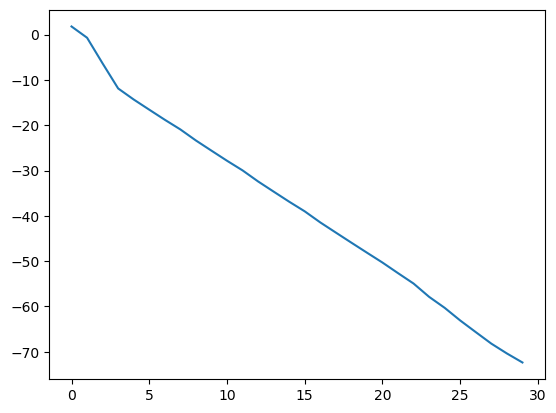

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141ac1518>

In [15]:
plot(log.(fn_value))

## For PDE

Background setting

In [156]:
Nx = 51;
Ny = 51;
h = 0.02;

Fs = 250;
dt = 1/Fs
Nt = 501;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
# plot(t,source); title("ricker source")
source_position = zeros(6,2)
for i = 1:6
#     source_position[i,:] = [3,(i-1)*10+1]
    source_position[i,:] = [(i-1)*10+1,1]
end
source = repeat(source, 1, 6)

receiver_position = zeros(26,2)
for i = 1:26
#     receiver_position[i,:] = [1,(i-1)*2+1]
    receiver_position[i,:] = [(i-1)*2+1,51]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)

c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[25:end,:] .= 1.2;
c0[20:30,20:30] .= 1.2

c = imfilter(c0, Kernel.gaussian(10));

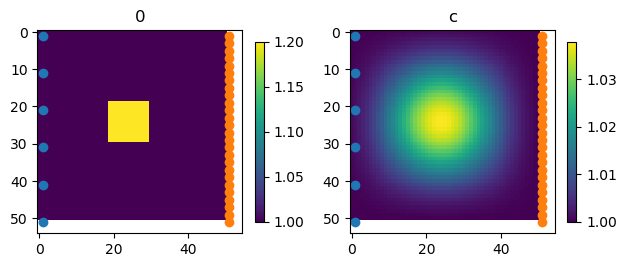

In [157]:
figure; 
subplot(121); imshow(c0); colorbar(shrink=0.4); title("0")
scatter(source_position[:,2], source_position[:,1])
scatter(receiver_position[:,2], receiver_position[:,1])
subplot(122); imshow(c); colorbar(shrink=0.4); title("c")
scatter(source_position[:,2], source_position[:,1])
scatter(receiver_position[:,2], receiver_position[:,1])
tight_layout()

In [138]:
@time data, u = multi_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

  7.721597 seconds (604.47 k allocations: 10.689 GiB, 27.88% gc time)
  8.008541 seconds (604.46 k allocations: 10.689 GiB, 26.58% gc time)


In [139]:
function obj_fn(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100)
    x = reshape(c, Nx, Ny)

    data, u = multi_solver(x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)

    fk = 0.5 * norm(data - data0) ^ 2

    gradk = grad_l2(data, u, data0, x, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

    gradk = reshape(gradk, Nx*Ny, 1)
    return fk, gradk
end

obj_fn_gd(x) = obj_fn(x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100)


obj_fn_gd (generic function with 1 method)

In [159]:
xk = c[:]
@time fk, gradk = obj_fn_gd(xk);

pk = -gradk
alpha = 0.2
xkk = xk+alpha*pk
xkk[findall(ind->ind<1,xk)] .= 1
xkk[findall(ind->ind>1.2,xk)] .= 1.2
@time fk1, gradk1 = obj_fn_gd(xkk)

 17.315672 seconds (1.21 M allocations: 21.962 GiB, 27.68% gc time)
 16.532823 seconds (1.21 M allocations: 21.962 GiB, 27.28% gc time)


(10.44062059706672, [0.3124602072491041; 0.23155701899947645; … ; 0.09894644391107359; 0.10493352360300287])

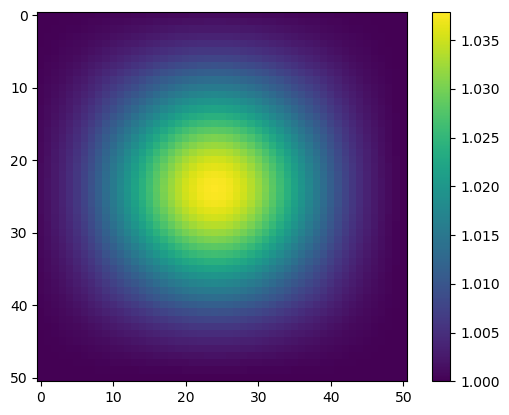

PyObject <matplotlib.colorbar.Colorbar object at 0x145437940>

In [160]:
imshow(reshape(xk, Nx, Ny)); colorbar()

In [161]:
println(fk)
println(fk1)

1.3083493489058173
10.44062059706672


In [147]:
fk1 < fk + (1e-3)*alpha*sum(gradk.*pk)

false

In [114]:
xkkk, fkkk, gradkkk = line_search_backtracking(obj_fn_gd, xk, fk, gradk, 0.2, 1, 1.2; rho=0.9, c=1e-1, maxSearchTime=3)

3.134364858013112
Line search succeed. Search time: 0.


([0.9906541490323164; 1.038941471049883; … ; 1.1210799751672316; 1.121883917660649], 3.134364858013112, [0.31910303197007206; 0.1582855039084579; … ; -1.3701539738490607e-5; -1.649534646341672e-5])

In [115]:
xkkk == xkk

true

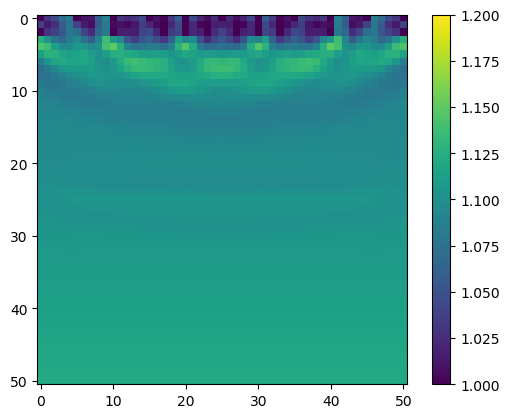

PyObject <matplotlib.colorbar.Colorbar object at 0x1458ac940>

In [117]:
imshow(reshape(xkkk, Nx, Ny)); clim(1,1.2); colorbar()

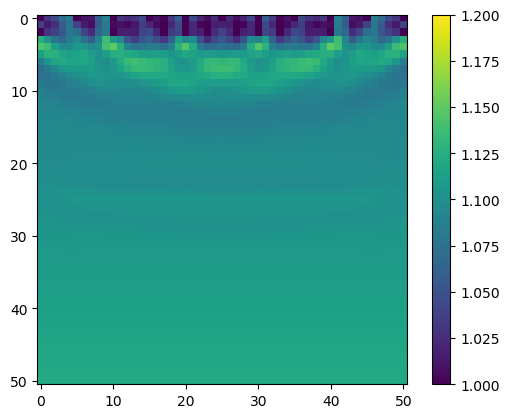

PyObject <matplotlib.colorbar.Colorbar object at 0x1448b21d0>

In [118]:
imshow(reshape(xkk, Nx, Ny)); clim(1,1.2); colorbar()

In [140]:
xxx, fff = gradient_descent(obj_fn_gd, c, 0.2, 3, 1, 1.2; rho=0.9, c=1e-3, maxSearchTime=3)

Main iteration: 1
13.594383958876985
Line search failed. Search time: 3. Try to decrease search coef c.
Line search Failed. Try decrease line search coef alpha. Interupt.
--------------------------------


([1.0003982628222319, 1.000399198902687, 1.000400097211589, 1.0004009574842665, 1.0004017794668767, 1.000402562916531, 1.0004033076014136, 1.0004040133008973, 1.0004046798056514, 1.0004053069177448  …  1.0004020002853398, 1.0004012981020374, 1.0004005571275825, 1.0003997775815037, 1.0003989596944614, 1.0003981037081335, 1.0003972098750982, 1.0003962784587086, 1.000395309732963, 1.0003943039823715], [2.756311234733806, 0.0, 0.0, 0.0])

In [142]:
fff

4-element Array{Float64,1}:
 2.756311234733806
 0.0              
 0.0              
 0.0              

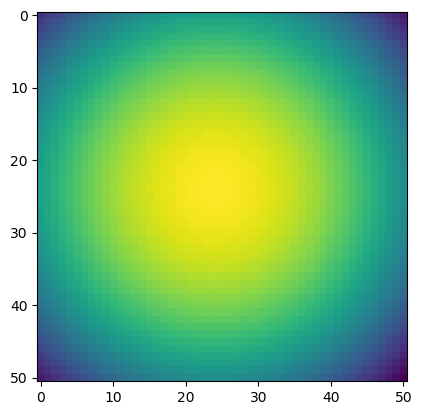

PyObject <matplotlib.image.AxesImage object at 0x1452c04a8>

In [143]:
imshow(reshape(xxx, Nx, Ny))

In [115]:
@time ff, gg = obj_fn(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

 16.598494 seconds (1.25 M allocations: 21.961 GiB, 27.95% gc time)


In [116]:
ff
gg = reshape(gg, Nx, Ny)

51×51 Array{Float64,2}:
 -0.454587     -0.214733     -0.151981     …  -0.214733     -0.454587   
 -0.150842     -0.307609     -0.262874        -0.307609     -0.150842   
 -0.428591     -0.224541     -0.188989        -0.224541     -0.428591   
  0.300202      0.184245      0.0334168        0.184245      0.300202   
  0.347502      0.338149      0.224473         0.338149      0.347502   
  0.128042      0.245008      0.272585     …   0.245008      0.128042   
 -0.0389611     0.0742095     0.169309         0.0742095    -0.0389611  
 -0.0900896    -0.0482247     0.0233226       -0.0482247    -0.0900896  
 -0.0665846    -0.0789597    -0.0586675       -0.0789597    -0.0665846  
 -0.0260373    -0.0535946    -0.0667594       -0.0535946    -0.0260373  
  0.00054085   -0.0191492    -0.0390821    …  -0.0191492     0.00054085 
  0.00969778    0.00168929   -0.0104532        0.00168929    0.00969778 
  0.00907875    0.00793911    0.00418021       0.00793911    0.00907875 
  ⋮                        

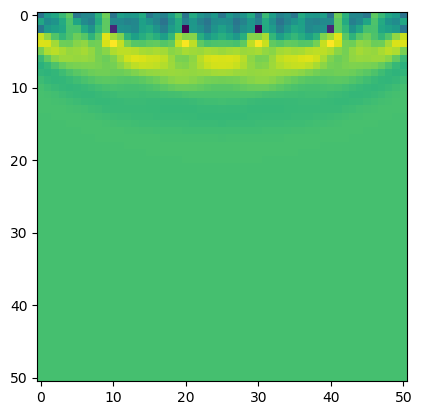

PyObject <matplotlib.image.AxesImage object at 0x14b07f080>

In [117]:
imshow(gg)

In [164]:
# @time cc, fv = gradient_descent(obj_fn_gd, c, 0.05, 3, 1, 1.2; rho=0.9, c=0.9, maxSearchTime=5);

In [119]:
# xk = c[:];

In [178]:
iterNum = 3
fn_value = zeros(iterNum+1);
fk, gradk = obj_fn_gd(xk)
# fn_value[1] = fk

(3.6598665337417997, [0.45616509673195205; 0.15155086590007902; … ; -8.428027975450123e-5; -5.421498777247682e-5])

In [179]:
alpha = 0.1
pk = -gradk
fk1, gradk1 = obj_fn_gd(xk+alpha*pk)

(2.97172001582138, [0.3976682698418524; 0.16213753109763634; … ; -7.066715845811506e-5; -4.155131449595898e-5])

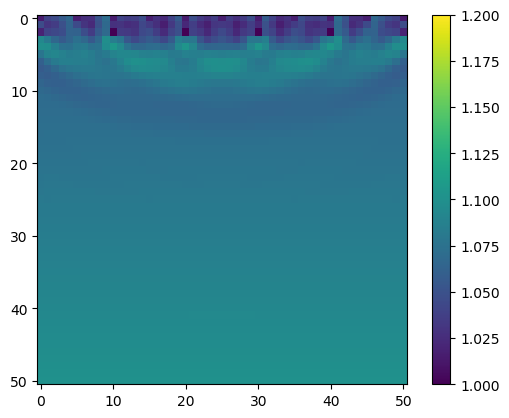

In [181]:
imshow(reshape(xk+alpha*pk,Nx,Ny)); colorbar(); clim(1,1.2)

In [172]:
imshow(reshape(gradk)); colorbar()

DimensionMismatch: DimensionMismatch("new dimensions () must be consistent with array size 2601")

In [177]:
for iter = 1:iterNum
    println("Main iteration: ", iter)
    xk1, fk, gradk = line_search_backtracking(obj_fn_gd, xk, fk, gradk, 0.1; rho=0.9, c=0.9, maxSearchTime=3)

    if xk1 == xk
        println("Line search Failed. Try decrease line search coef alpha. Interupt.")
        break
    else
        xk = xk1
    end

    xk[findall(ind->ind<min_value,xk)] .= min_value
    xk[findall(ind->ind>max_value,xk)] .= max_value

    fn_value[iter+1] = fk
    println("--------------------------------")
end

Main iteration: 1
Line search failed. Search time: 3.
Line search Failed. Try decrease line search coef alpha. Interupt.


In [130]:
c = 0.9
rho = 0.9
alpha = 1
fk1 < fk + c*alpha*sum(gradk.*pk)

DimensionMismatch: DimensionMismatch("arrays could not be broadcast to a common size")

In [137]:
c*alpha*sum(gradk.*pk)

-25.013675002841026

In [136]:
pk = -gradk

2601×1 Array{Float64,2}:
  0.4545866760469066    
  0.1508416202895164    
  0.42859050508044677   
 -0.30020182779695903   
 -0.3475024486846541    
 -0.12804174113837344   
  0.03896111852623134   
  0.09008955069428815   
  0.06658464457109699   
  0.026037280847689956  
 -0.0005408501542766505 
 -0.009697783075871205  
 -0.009078752928556479  
  ⋮                     
  2.759792507817878e-5  
 -8.211897278472654e-6  
  7.374293548548455e-5  
 -4.062889024686723e-5  
 -0.00018947700296496542
 -0.00010450966999072937
  9.419055651264427e-5  
  0.00018122383828905292
  9.70972122285367e-5   
 -3.477811487177133e-5  
 -8.609437022319292e-5  
 -5.60941704908903e-5   